## Duration - Differential Entropy and Control functions 

In [2]:
from src.data.components.helsinki import HelsinkiProminenceExtractor
from src.data.components.datasets import TokenTaggingDataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
import numpy as np
import os
from tqdm import tqdm

from src.utils.text_processing import python_lowercase_remove_punctuation
from src.utils.text_processing import get_wordlist_from_string

# only to create a valid dataset
dummy_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_special_tokens=True)

### Load data

In [3]:
WAV_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTS"
LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel"
PHONEME_LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabelPhoneme"
DATA_CACHE = "/Users/lukas/Desktop/projects/MIT/data/cache"

TRAIN_FILE = "train-clean-360"
VAL_FILE = "dev-clean"
TEST_FILE = "test-clean"

SAVE_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/emnlp/duration"

In [4]:
from src.data.duration_regression_datamodule import (
    DurationRegressionDataModule as DataModule,
)

In [5]:
dm = DataModule(
    wav_root=WAV_ROOT,
    lab_root=LAB_ROOT,
    phoneme_lab_root=PHONEME_LAB_ROOT,
    data_cache=DATA_CACHE,
    train_file=TRAIN_FILE,
    val_file=VAL_FILE,
    test_file=TEST_FILE,
    dataset_name="libritts",
    model_name="gpt2",
    word_duration_mode="syllable_norm",
    score_last_token=True,
)

In [6]:
dm.setup()

Using GPT2 tokenizer
Dataloader: padding with token id: 50256
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/train-clean-360', 'duration_syllable_norm')


Preprocessing samples: 100%|██████████| 108321/108321 [01:02<00:00, 1735.50it/s]


Failed 6878/108321
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/dev-clean', 'duration_syllable_norm')


Preprocessing samples: 100%|██████████| 4217/4217 [00:02<00:00, 1890.54it/s]


Failed 217/4217
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/test-clean', 'duration_syllable_norm')


Preprocessing samples: 100%|██████████| 4389/4389 [00:02<00:00, 1906.15it/s]

Failed 270/4389
Train dataset size: 101443
Validation dataset size: 4000
Test dataset size: 4119


In [7]:
train_texts, train_labels = dm.train_texts, dm.train_durations
val_texts, val_labels = dm.val_texts, dm.val_durations
test_texts, test_labels = dm.test_texts, dm.test_durations

print(
    f"Lengths of train, val, test in samples: {len(train_texts), len(val_texts), len(test_texts)}"
)

Lengths of train, val, test in samples: (108321, 4217, 4389)


In [8]:
from src.utils.text_processing import assign_labels_to_sentences

all_train_words, all_train_labels = assign_labels_to_sentences(
    train_texts, train_labels
)
all_dev_words, all_dev_labels = assign_labels_to_sentences(val_texts, val_labels)
all_test_words, all_test_labels = assign_labels_to_sentences(test_texts, test_labels)

print(f"Words and labels train: {len(all_train_words), len(all_train_labels)}")
print(f"Words and labels dev: {len(all_dev_words), len(all_dev_labels)}")
print(f"Words and labels test: {len(all_test_words), len(all_test_labels)}")

Words and labels train: (1875477, 1875477)
Words and labels dev: (72537, 72537)
Words and labels test: (77979, 77979)


### Kernel density estimation and Differential Entropy Computation

In [9]:
# bootstrapping to get confidence intervals
from sklearn.utils import resample
from scipy.stats import gaussian_kde
from src.utils.approximation import cross_validate_gkde_bandwidth
from src.utils.approximation import monte_carlo_diff_entropy

n_iterations = 10
n_train_size = int(len(all_train_labels) * 0.5)
n_dev_size = int(len(all_dev_labels) * 0.2)
n_test_size = int(len(all_test_labels) * 0.1)
print(
    f"n_train_size: {n_train_size}, n_dev_size: {n_dev_size}, n_test_size: {n_test_size}"
)

diff_entropy_list = []

for i in range(n_iterations):
    train_sample = resample(all_train_labels, n_samples=n_train_size)
    dev_sample = resample(all_dev_labels, n_samples=n_dev_size)
    test_sample = resample(all_test_labels, n_samples=n_test_size)
    best_bw = 0.1
    # best_bw = cross_validate_gkde_bandwidth(train_sample, dev_sample)
    print(f"Best bandwidth: {best_bw}")
    density = gaussian_kde(all_train_labels, bw_method=best_bw)
    mc_entropy = monte_carlo_diff_entropy(density, test_sample, len(test_sample))
    diff_entropy_list.append(mc_entropy)
    print(
        f"Finished iteration {i+1} out of {n_iterations} with diff entropy: {mc_entropy}"
    )

diff_entropy_list = np.array(diff_entropy_list)
print(f"Mean: {np.mean(diff_entropy_list)}, std: {np.std(diff_entropy_list)}")

n_train_size: 937738, n_dev_size: 14507, n_test_size: 7797
Best bandwidth: 0.1
Finished iteration 1 out of 10 with diff entropy: -0.9220232834116704
Best bandwidth: 0.1
Finished iteration 2 out of 10 with diff entropy: -0.937440693875117
Best bandwidth: 0.1
Finished iteration 3 out of 10 with diff entropy: -0.9235853904232577
Best bandwidth: 0.1
Finished iteration 4 out of 10 with diff entropy: -0.9127031405763055
Best bandwidth: 0.1
Finished iteration 5 out of 10 with diff entropy: -0.926932748754513
Best bandwidth: 0.1
Finished iteration 6 out of 10 with diff entropy: -0.9122648770829699
Best bandwidth: 0.1
Finished iteration 7 out of 10 with diff entropy: -0.9182676367179848
Best bandwidth: 0.1
Finished iteration 8 out of 10 with diff entropy: -0.922749608297809
Best bandwidth: 0.1
Finished iteration 9 out of 10 with diff entropy: -0.9231811554102718
Best bandwidth: 0.1
Finished iteration 10 out of 10 with diff entropy: -0.9042789176212221
Mean: -0.9203427452171121, std: 0.008654043

In [10]:
from src.utils.approximation import cross_validate_gkde_bandwidth

best_bw = cross_validate_gkde_bandwidth(
    all_train_labels[:20000], all_test_labels[:5000]
)
print(f"best bw {best_bw}")

param scott, score 0.8348294129893067
new best param scott, score 0.8348294129893067
param silverman, score 0.8343002016407538
param 0.01, score 1.6103370559591106
new best param 0.01, score 1.6103370559591106
param 0.1, score 0.8367820217698754
param 0.3, score 0.8172856543219412
best bw 0.01


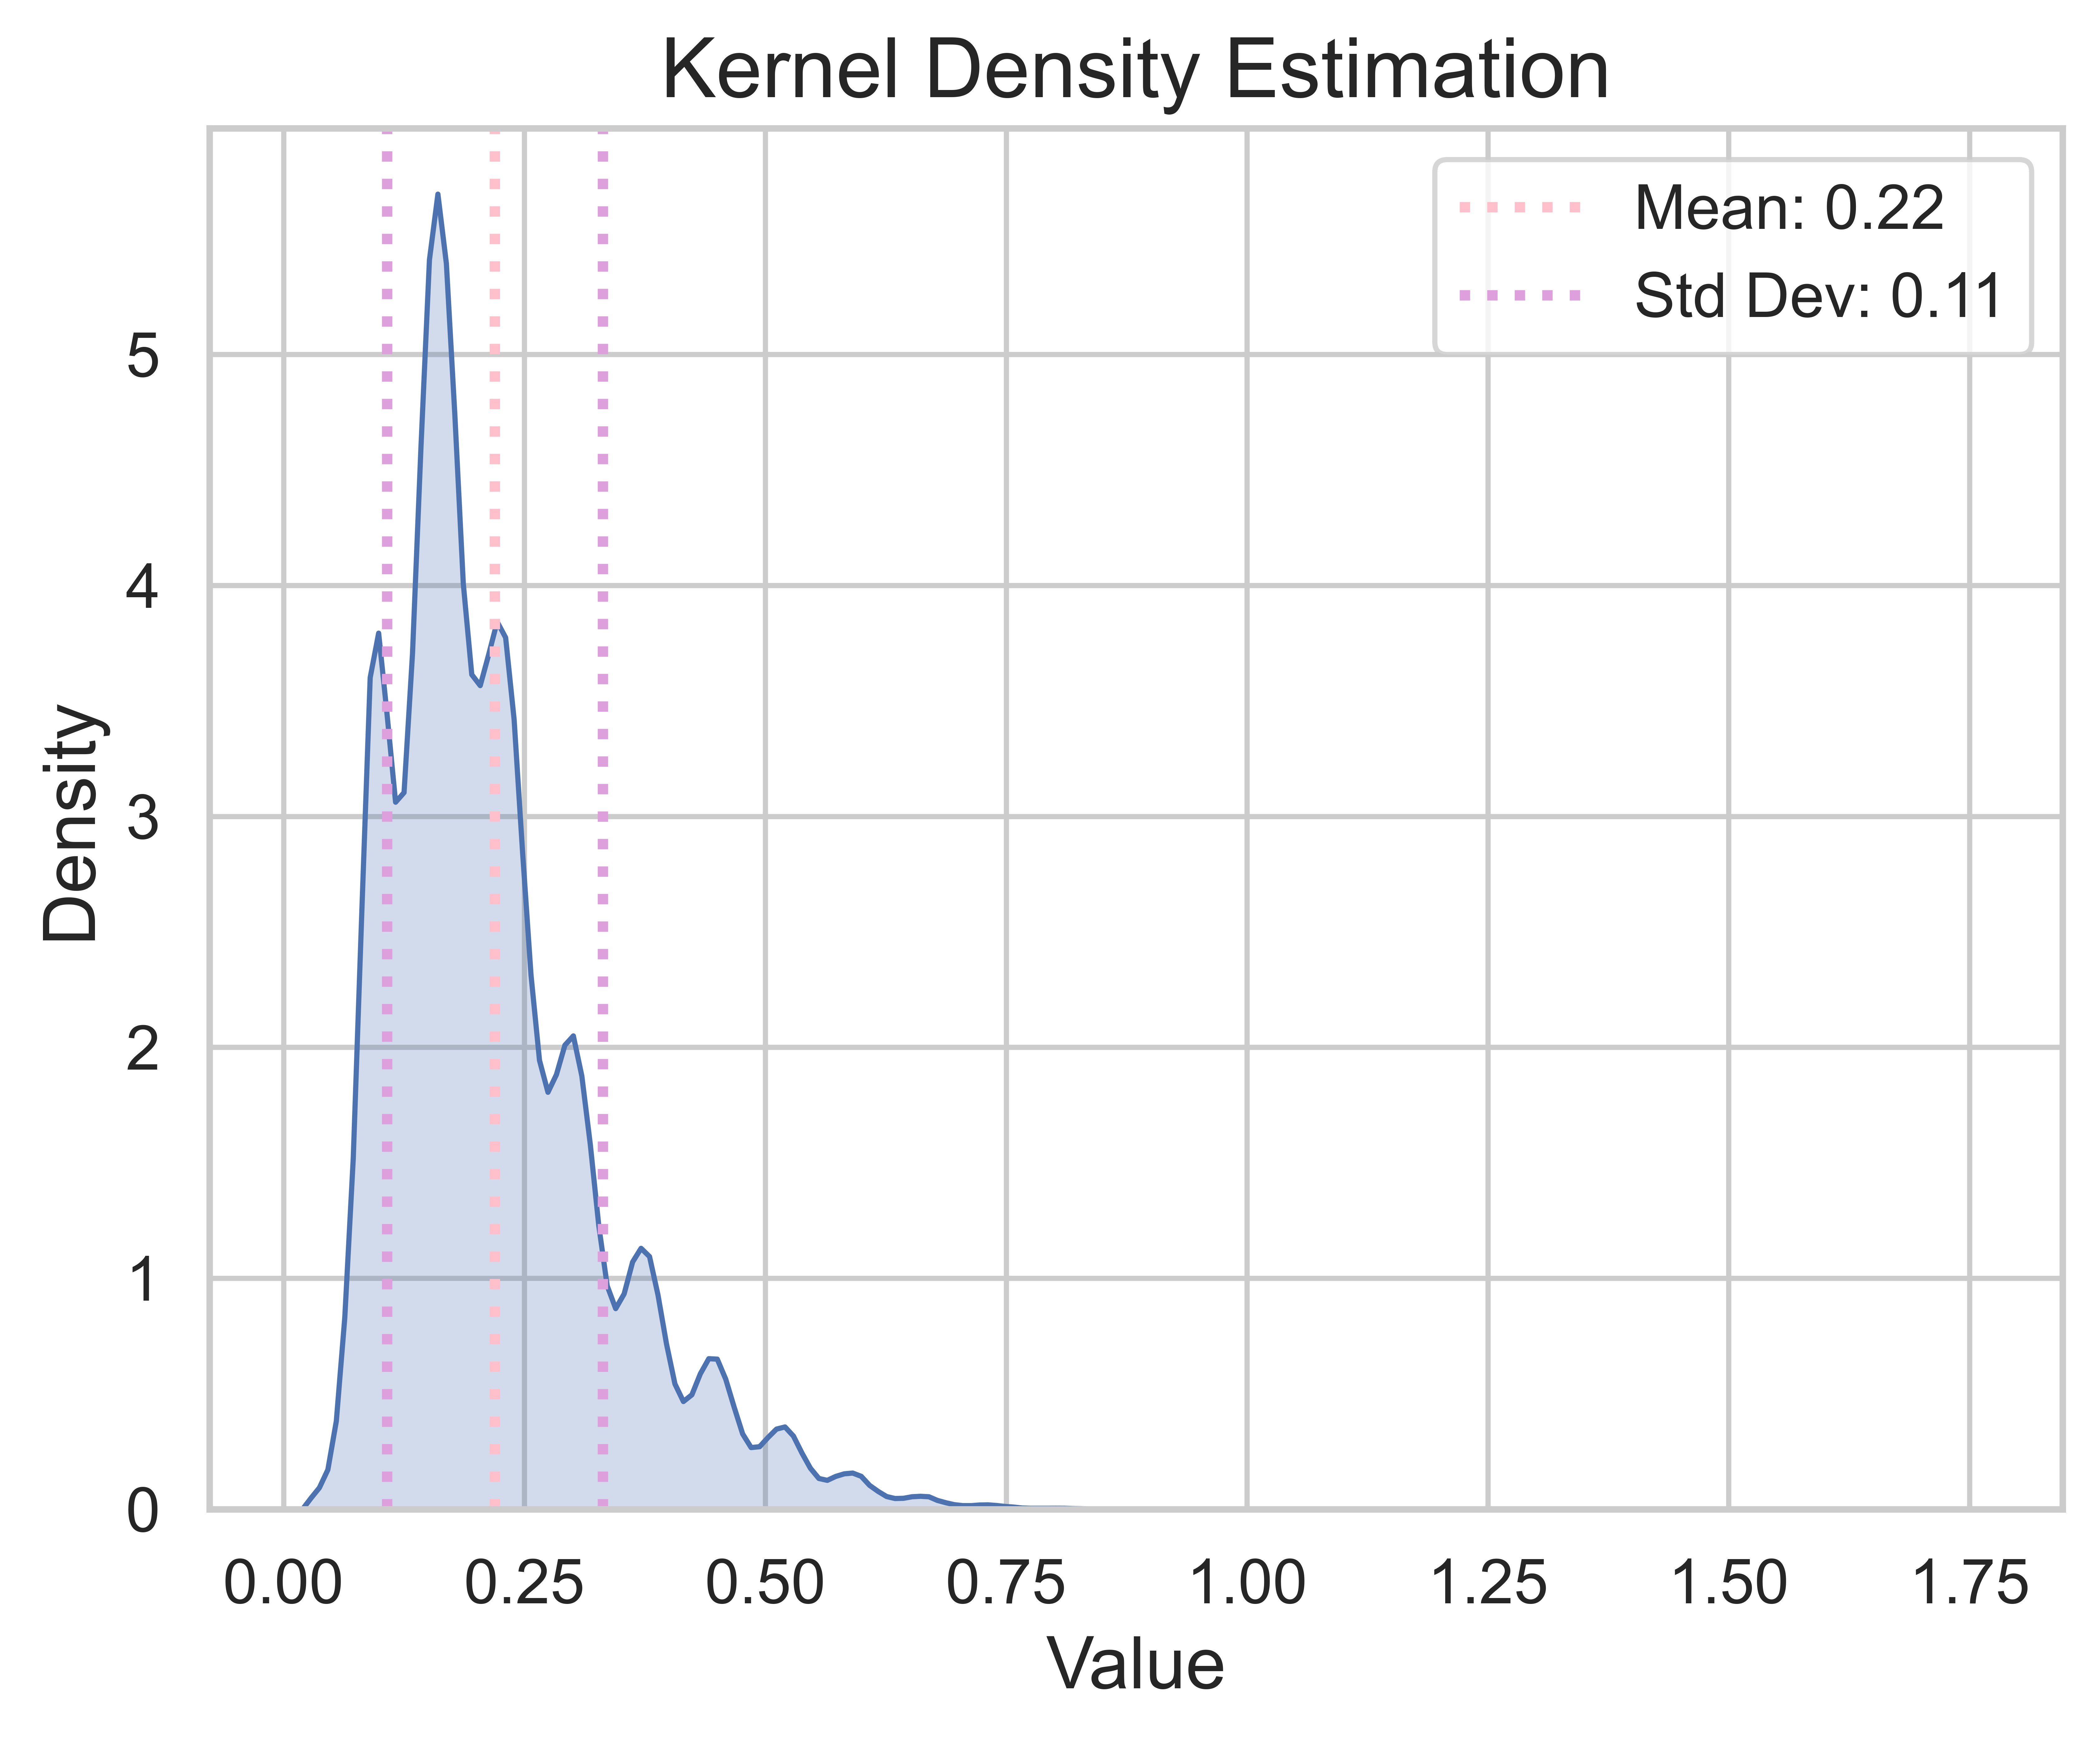

In [11]:
from src.utils.plots import plot_kde

plot_kde(all_train_labels, bw_adjust=0.5)

In [12]:
# kernel density estimation
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

density = gaussian_kde(all_train_labels, bw_method=0.5)

# xs = np.linspace(0, 6, 1000)
# plt.plot(xs, density(xs))
# plt.show()

In [13]:
from src.utils.approximation import monte_carlo_diff_entropy

diff_entropy = monte_carlo_diff_entropy(density, all_test_labels, 5000)
print(f"Differential entropy: {diff_entropy:.4f}")

Differential entropy: -0.8704


## Store text and labels as pickle 

In [14]:
SAVE_PATH = "/Users/lukas/Desktop/projects/MIT/data/baseline_data/duration_syll"

In [15]:
import pickle

with open(SAVE_PATH + "/train_words.pkl", "wb") as f:
    pickle.dump(all_train_words, f)

with open(SAVE_PATH + "/train_labels.pkl", "wb") as f:
    pickle.dump(all_train_labels, f)

with open(SAVE_PATH + "/test_words.pkl", "wb") as f:
    pickle.dump(all_test_words, f)

with open(SAVE_PATH + "/test_labels.pkl", "wb") as f:
    pickle.dump(all_test_labels, f)

with open(SAVE_PATH + "/dev_words.pkl", "wb") as f:
    pickle.dump(all_dev_words, f)

with open(SAVE_PATH + "/dev_labels.pkl", "wb") as f:
    pickle.dump(all_dev_labels, f)

# Baseline Models and Control Functions 

In [16]:
SAVE_PATH = "/Users/lukas/Desktop/projects/MIT/data/baseline_data/duration_syll"

In [17]:
# load data again

import pickle


with open(SAVE_PATH + "/train_words.pkl", "rb") as f:
    all_train_words = pickle.load(f)

with open(SAVE_PATH + "/train_labels.pkl", "rb") as f:
    all_train_labels = pickle.load(f)

with open(SAVE_PATH + "/test_words.pkl", "rb") as f:
    all_test_words = pickle.load(f)

with open(SAVE_PATH + "/test_labels.pkl", "rb") as f:
    all_test_labels = pickle.load(f)

with open(SAVE_PATH + "/dev_words.pkl", "rb") as f:
    all_dev_words = pickle.load(f)

with open(SAVE_PATH + "/dev_labels.pkl", "rb") as f:
    all_dev_labels = pickle.load(f)

print(len(all_train_words), len(all_train_labels))
print(len(all_dev_words), len(all_dev_labels))
print(len(all_test_words), len(all_test_labels))

1875477 1875477
72537 72537
77979 77979


In [18]:
from src.models.baselines.GloVe import GloVeModel

glove_model = GloVeModel(
    model_path="/Users/lukas/Desktop/projects/MIT/data/models/glove/glove.6B.100d.txt"
)

Loading GloVe: 100%|██████████| 400000/400000 [00:06<00:00, 58745.59it/s]


In [19]:
train_emb = [glove_model.get_word_embedding(word) for word in all_train_words]
dev_emb = [glove_model.get_word_embedding(word) for word in all_dev_words]
test_emb = [glove_model.get_word_embedding(word) for word in all_test_words]

print(
    f"Shapes of train, dev, test embeddings: {len(train_emb)}, {len(dev_emb)}, {len(test_emb)}"
)

# create numpy arrays and print shapes
import numpy as np

train_emb = np.array(train_emb)
dev_emb = np.array(dev_emb)
test_emb = np.array(test_emb)

train_labels = np.array(all_train_labels)
dev_labels = np.array(all_dev_labels)
test_labels = np.array(all_test_labels)


print(
    f"Shapes of train, dev, test embeddings: {train_emb.shape}, {dev_emb.shape}, {test_emb.shape}"
)

print(
    f"Shapes of train, dev, test labels: {train_labels.shape}, {dev_labels.shape}, {test_labels.shape}"
)

Shapes of train, dev, test embeddings: 1875477, 72537, 77979
Shapes of train, dev, test embeddings: (1875477, 100), (72537, 100), (77979, 100)
Shapes of train, dev, test labels: (1875477,), (72537,), (77979,)


# Sklearn LinReg

In [20]:
# train sklearn model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(train_emb, all_train_labels)

# compute mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

predictions = reg.predict(test_emb)
mse = mean_absolute_error(all_test_labels, predictions)
print(f"Mean absolute error: {mse}")

# compute r2
r2 = r2_score(all_test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(all_test_labels, predictions)
print(f"Pearson correlation: {pearson}")

Mean absolute error: 0.06801314790383338
R2 score: 0.3198345696083157
Pearson correlation: PearsonRResult(statistic=0.5659469979489208, pvalue=0.0)
